In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"C:/coding/kamp/unlabeled.csv"
unlabeled_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"C:/coding/kamp/labeled.csv"
labeled_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
unlabeled_df = useless_data_drop(unlabeled_df)
unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)


labeled_df = useless_data_drop(labeled_df)

C:\Users\wlsry\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-4-d1845d81cc9f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = unlabeled_df["ERR_FACT_QTY"] <= 0  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [8]:
# 이상치 측정 함수
def outlier(x):
    Q1 = x.quantile(1/4)
    Q3 = x.quantile(3/4)
    IQR = Q3 - Q1
    LL = Q1 - (1.5*IQR)
    UU = Q3 + (1.5*IQR)
    outlier = (x < LL) | (x > UU)
    return outlier

# unlabeled데이터 분석 후 사용 안하는 데이터 제거

In [9]:
# 종속 변수 제거
CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2
unlabeled_CN7_650T_train = CN7_650T_df.drop(["Barrel_Temperature_7", "PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)
# unlabeled_CN7_650T_train = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)

unlabeled_CN7_650T_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 500632 to 775136
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              2135 non-null   float64
 1   Plasticizing_Time         2135 non-null   float64
 2   Cycle_Time                2135 non-null   float64
 3   Clamp_Close_Time          2135 non-null   float64
 4   Cushion_Position          2135 non-null   float64
 5   Plasticizing_Position     2135 non-null   float64
 6   Clamp_Open_Position       2135 non-null   float64
 7   Max_Injection_Speed       2135 non-null   float64
 8   Max_Screw_RPM             2135 non-null   float64
 9   Average_Screw_RPM         2135 non-null   float64
 10  Max_Injection_Pressure    2135 non-null   float64
 11  Max_Switch_Over_Pressure  2135 non-null   float64
 12  Max_Back_Pressure         2135 non-null   float64
 13  Average_Back_Pressure     2135 non-null   float64
 14  B

<ipython-input-9-dad24cd2b492>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
<ipython-input-9-dad24cd2b492>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2


# labeled데이터 분석 후 사용 안하는 데이터 제거

In [10]:
# CN7_우진650톤 데이터 추출
CN7_filter = labeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = labeled_df["EQUIP_NAME"].str.contains("650")

labeled_df = labeled_df[CN7_filter & Eq650_filter]

# # Pass or Fail, Reason 데이터를 더미 변수로 변환
# label_encoder = preprocessing.LabelEncoder()
# onehot_encoder = preprocessing.OneHotEncoder()
# onehot_Reason = label_encoder.fit_transform(labeled_df["Reason"])
# labeled_df["Reason"] = onehot_Reason

# 데이터 분석 후 종속 변수 제거
labeled_df["Packing_Time"] = labeled_df["Injection_Time"] - labeled_df["Filling_Time"]
labeled_df["Avg_Mold_Temperature"] = (labeled_df["Mold_Temperature_3"] + labeled_df["Mold_Temperature_4"])/2
labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4","Barrel_Temperature_7" ], axis=1)
# labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)


# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

labeled_df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 5157
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              3946 non-null   float64
 1   Plasticizing_Time         3946 non-null   float64
 2   Cycle_Time                3946 non-null   float64
 3   Clamp_Close_Time          3946 non-null   float64
 4   Cushion_Position          3946 non-null   float64
 5   Plasticizing_Position     3946 non-null   float64
 6   Clamp_Open_Position       3946 non-null   float64
 7   Max_Injection_Speed       3946 non-null   float64
 8   Max_Screw_RPM             3946 non-null   float64
 9   Average_Screw_RPM         3946 non-null   float64
 10  Max_Injection_Pressure    3946 non-null   float64
 11  Max_Switch_Over_Pressure  3946 non-null   float64
 12  Max_Back_Pressure         3946 non-null   float64
 13  Average_Back_Pressure     3946 non-null   float64
 14  Barrel_T

C:\Users\wlsry\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

# 각 데이터 히스토그램 시각화

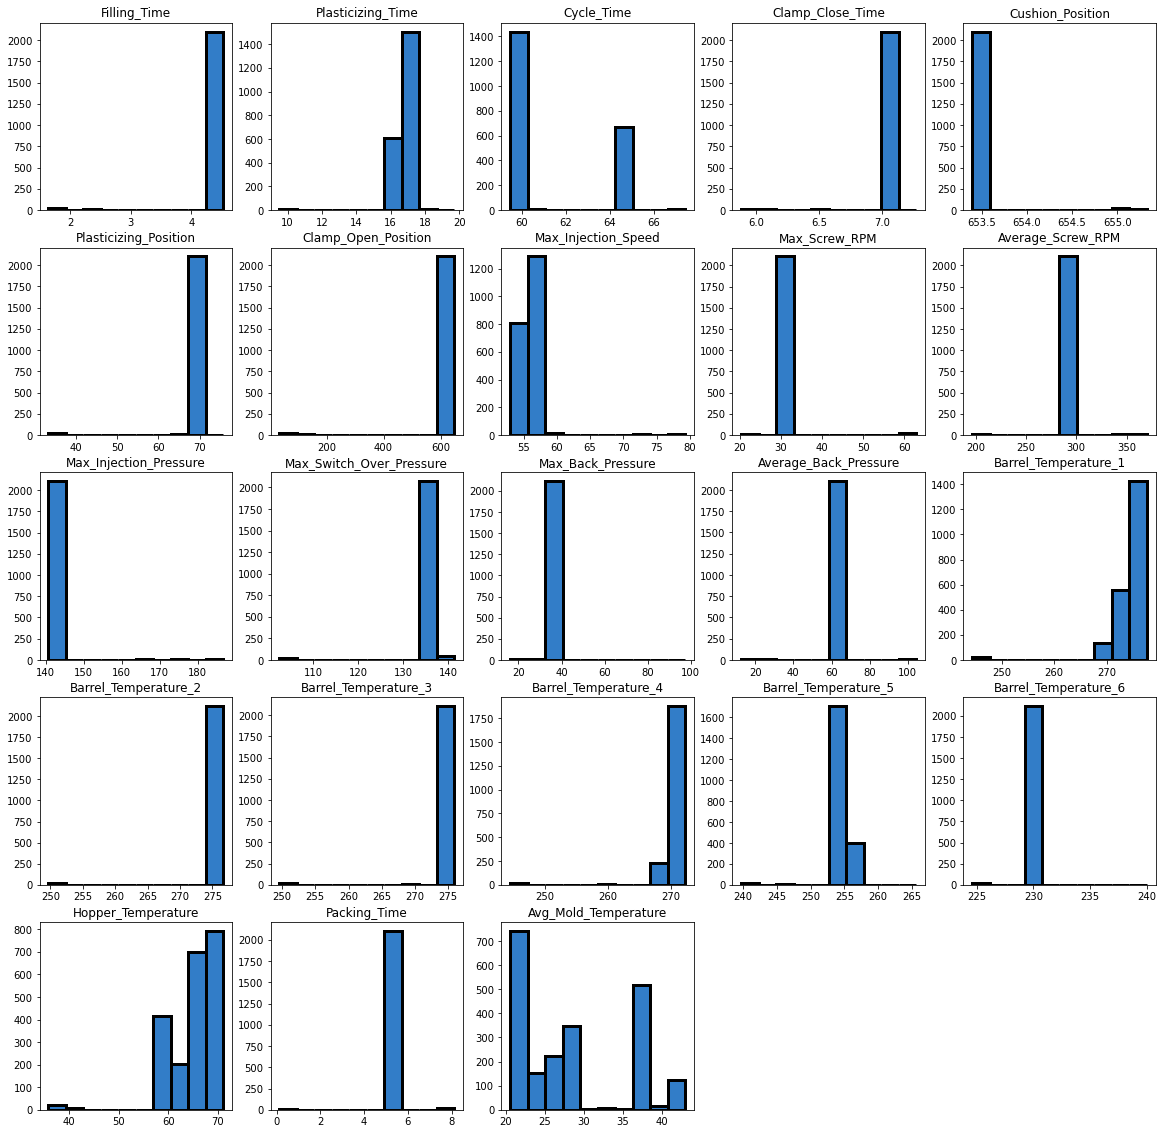

In [12]:
# unlabele데이터 히스토그램 시각화

data = unlabeled_CN7_650T_train
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

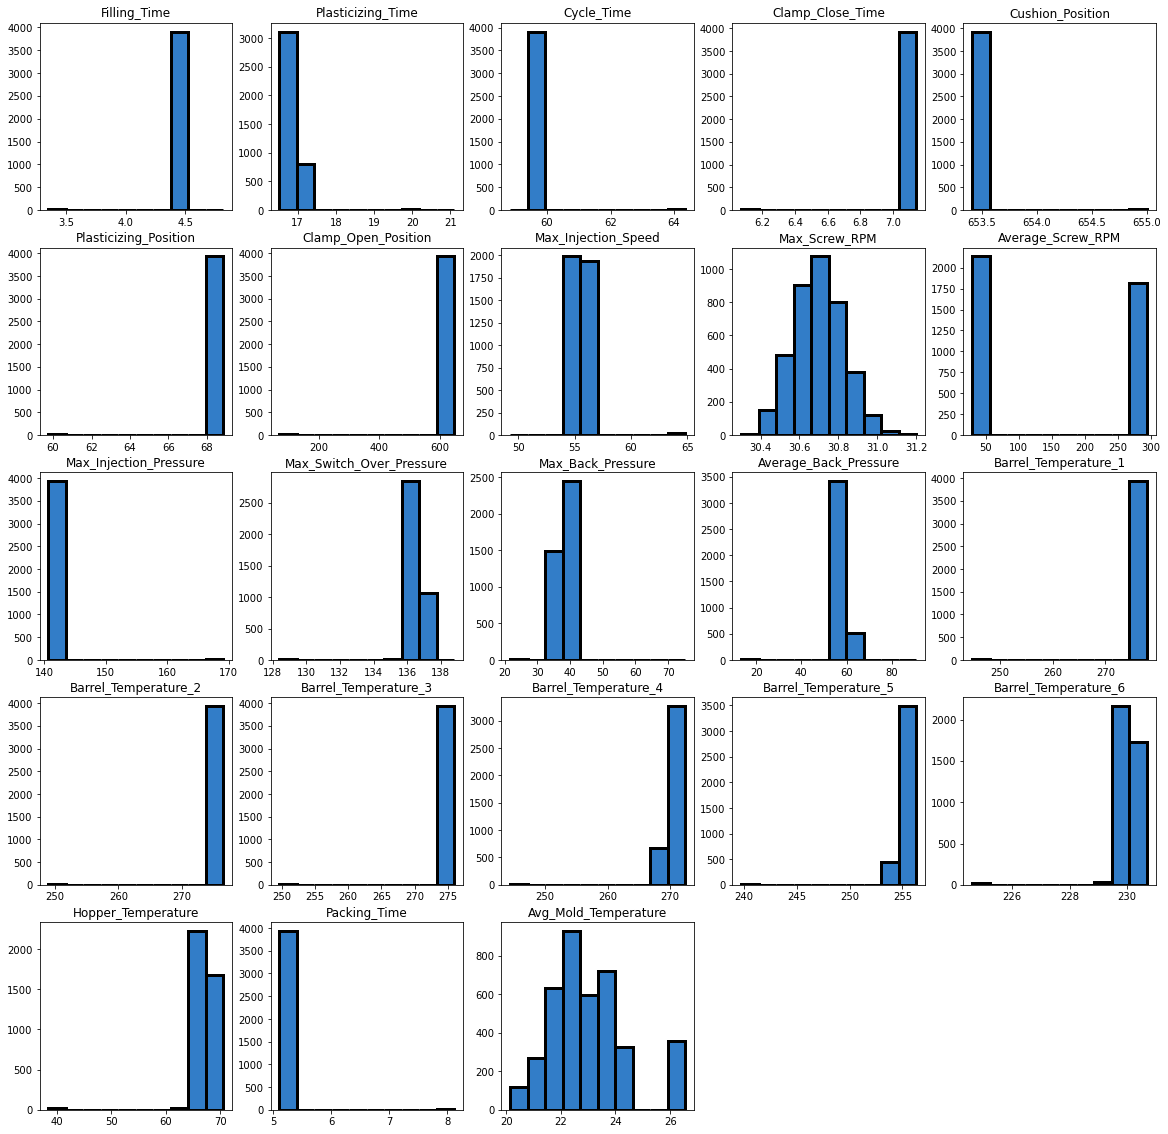

In [13]:
# labele데이터 히스토그램 시각화

data = labeled_df_Y
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# DAE 적용

In [14]:
# label+unlabeled train 데이터
train_df = pd.concat([unlabeled_CN7_650T_train, labeled_df_Y], ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6081 entries, 0 to 6080
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6081 non-null   float64
 1   Plasticizing_Time         6081 non-null   float64
 2   Cycle_Time                6081 non-null   float64
 3   Clamp_Close_Time          6081 non-null   float64
 4   Cushion_Position          6081 non-null   float64
 5   Plasticizing_Position     6081 non-null   float64
 6   Clamp_Open_Position       6081 non-null   float64
 7   Max_Injection_Speed       6081 non-null   float64
 8   Max_Screw_RPM             6081 non-null   float64
 9   Average_Screw_RPM         6081 non-null   float64
 10  Max_Injection_Pressure    6081 non-null   float64
 11  Max_Switch_Over_Pressure  6081 non-null   float64
 12  Max_Back_Pressure         6081 non-null   float64
 13  Average_Back_Pressure     6081 non-null   float64
 14  Barrel_T

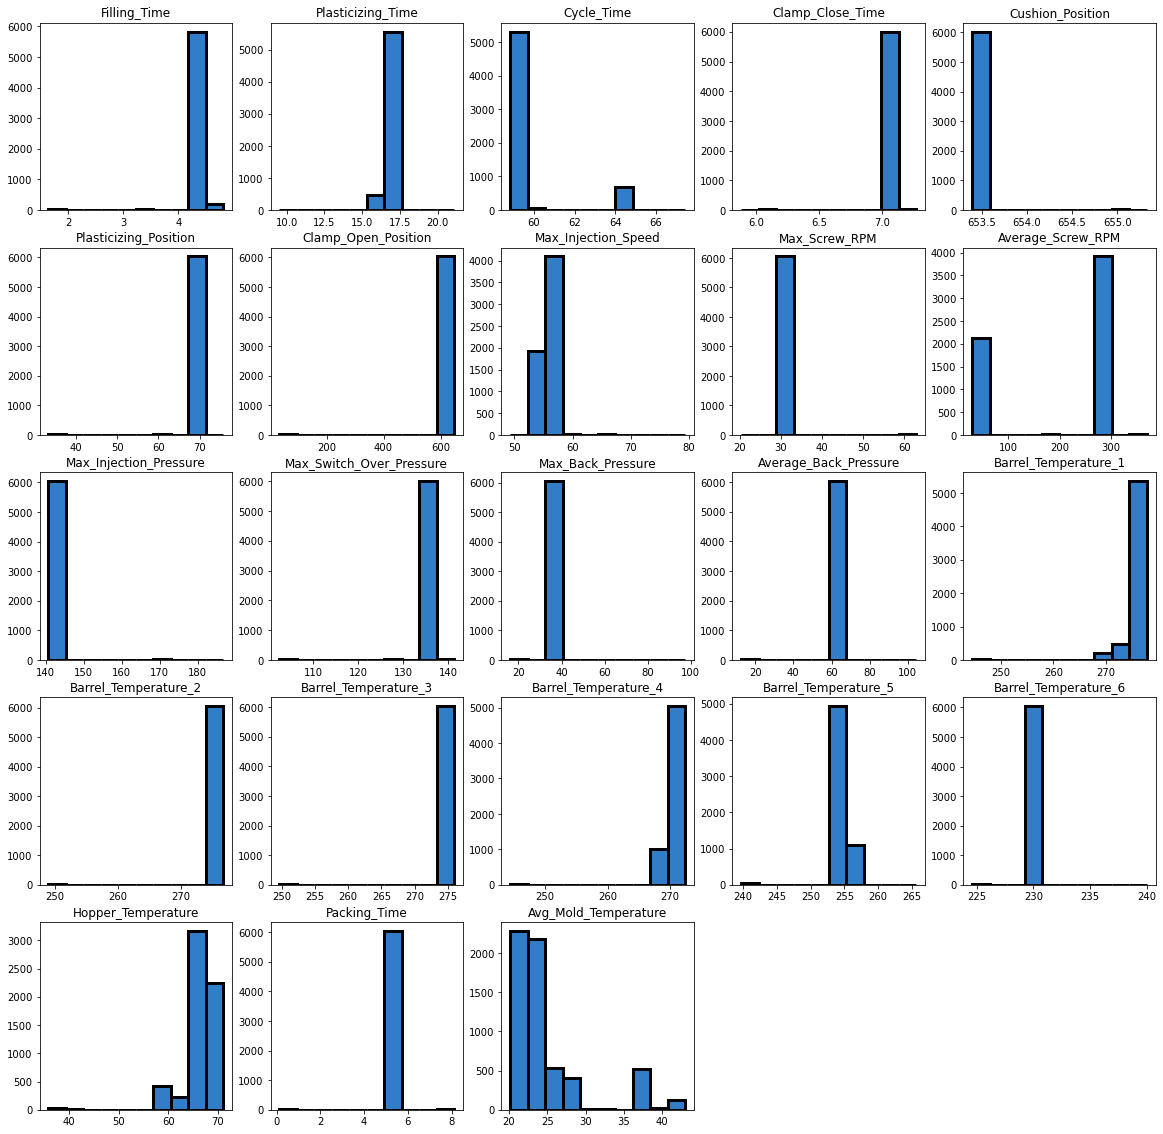

In [15]:
# train 데이터 히스토그램 시각화

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [15]:
train_df

,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,...,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Packing_Time,Avg_Mold_Temperature
0,4.46,16.470000,64.460000,7.11,653.390000,...,255.100000,230.000000,60.200000,5.11,38.10
1,4.47,16.470000,64.460000,7.09,653.390000,...,255.500000,230.000000,60.200000,5.12,37.95
2,4.46,16.500000,64.420000,7.10,653.390000,...,255.000000,230.000000,59.600000,5.12,37.95
3,4.46,16.470000,64.420000,7.10,653.390000,...,255.000000,230.100000,59.800000,5.12,37.70
4,4.49,16.450000,64.460000,7.10,653.390000,...,254.900000,230.300000,59.400000,5.12,37.80
...,...,...,...,...,...,...,...,...,...,...,...
6076,4.48,16.620001,59.560001,7.11,653.429993,...,255.600006,229.600006,66.099998,5.12,21.70
6077,4.48,16.650000,59.560001,7.11,653.429993,...,254.899994,230.000000,66.099998,5.12,21.70
6078,4.48,16.650000,59.560001,7.11,653.429993,...,254.899994,230.000000,66.099998,5.12,21.70
6079,4.48,16.629999,59.580002,7.11,653.429993,...,255.100006,230.199997,65.199997,5.12,21.65


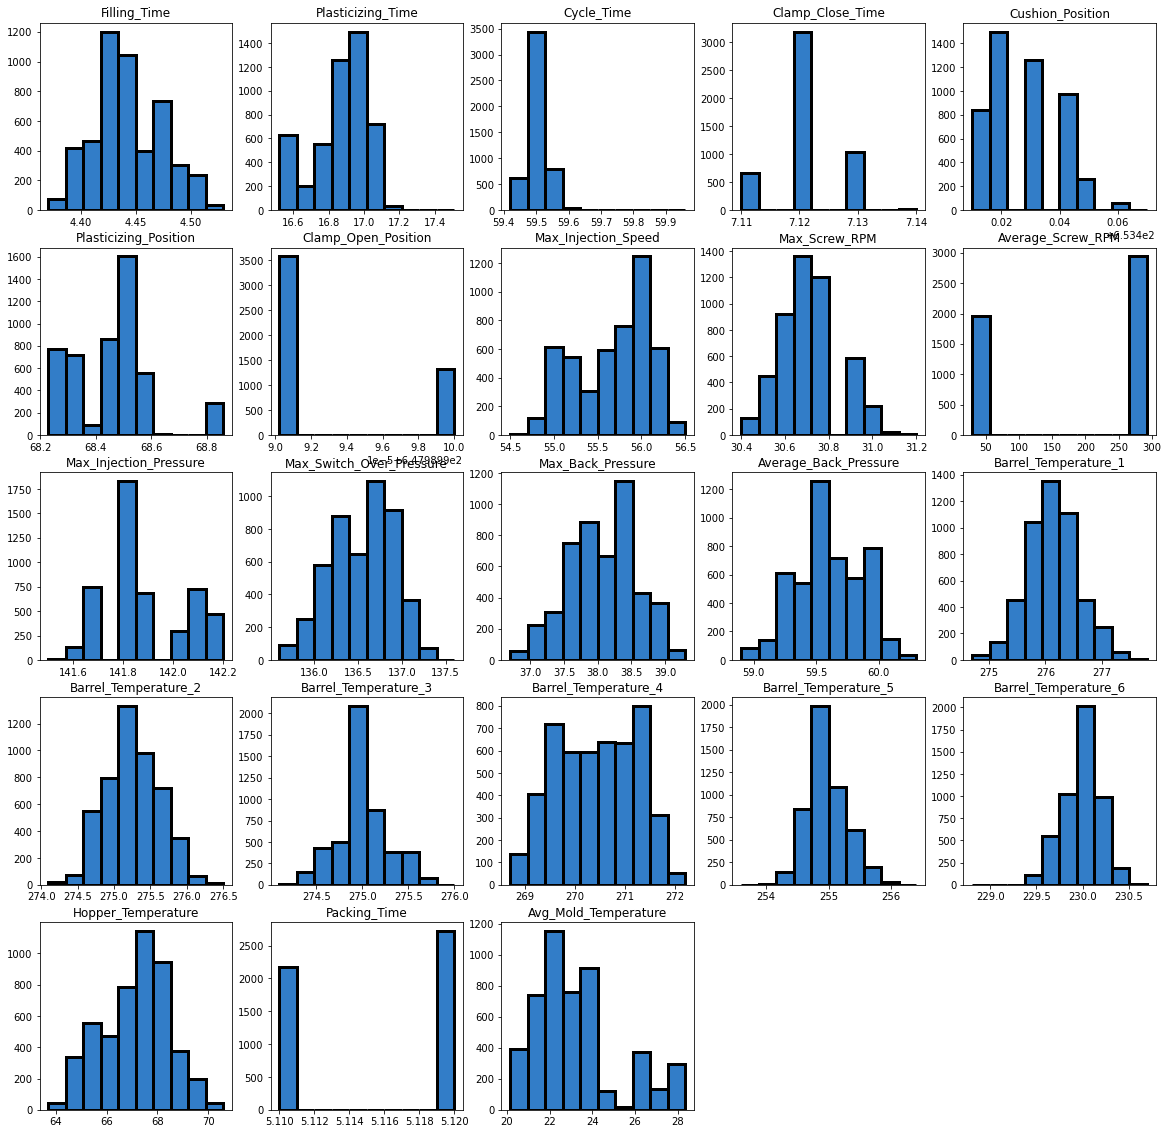

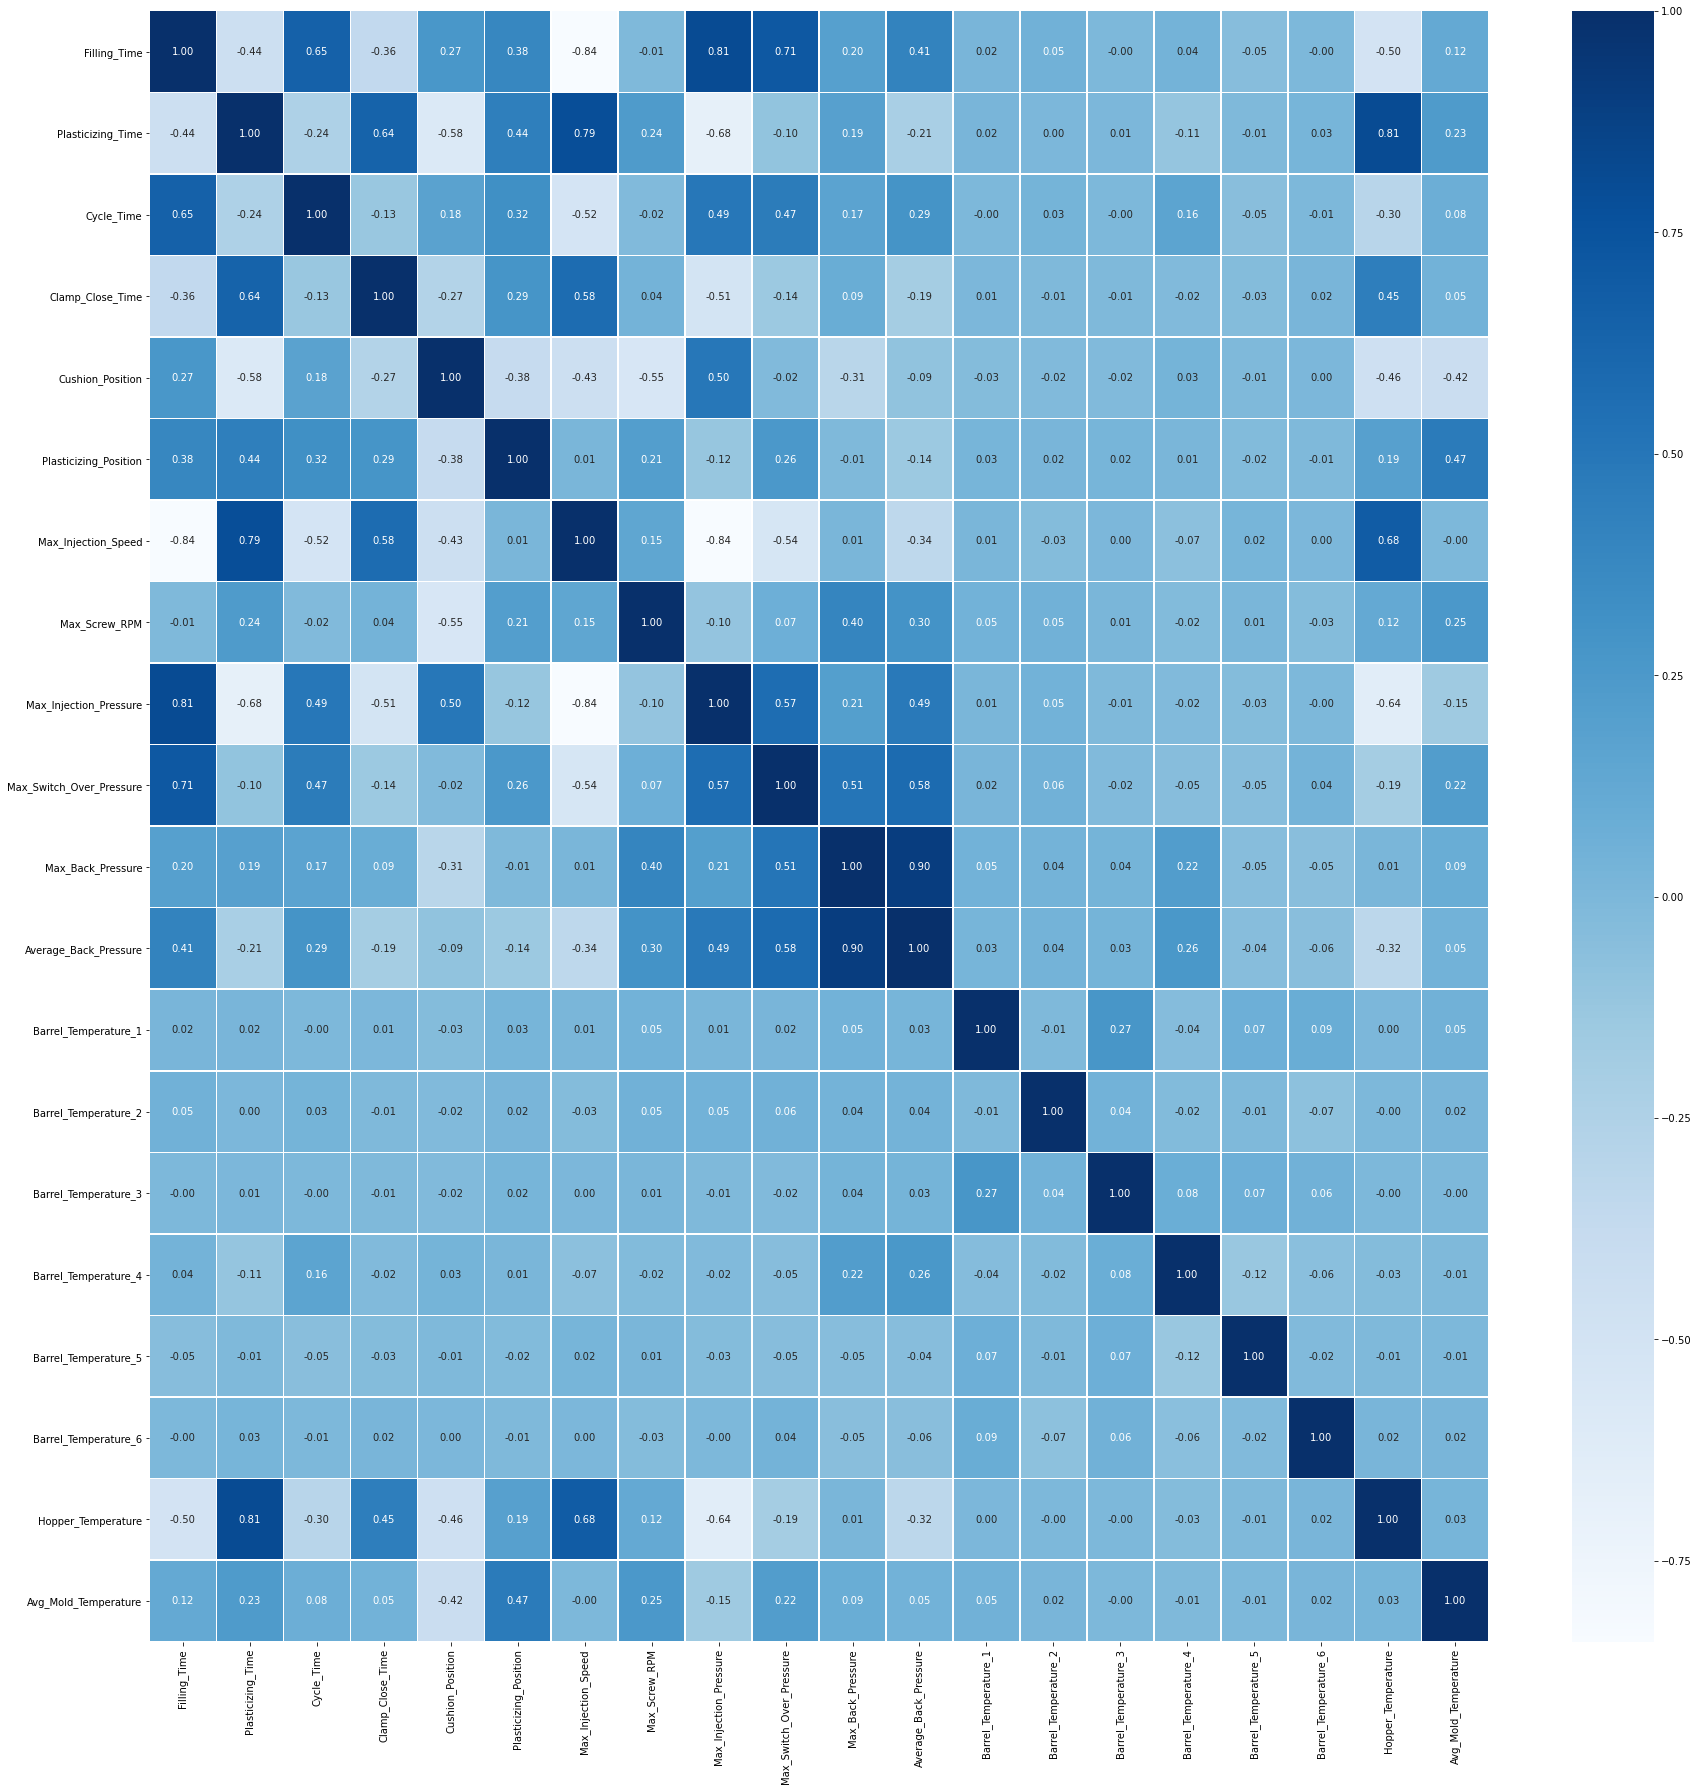

In [16]:
# outlier 제거
outlier_result = train_df.apply(outlier)
train_df = train_df[outlier_result.sum(axis=1) < 2]

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)
    
data = data.drop(["Clamp_Open_Position", "Average_Screw_RPM", "Packing_Time"], axis=1) 

# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 데이터 정규화
scaler = preprocessing.MinMaxScaler()
train_df = scaler.fit_transform(train_df)
labeled_df_N_test = scaler.transform(labeled_df_N_test)

# 학습, 평가데이터 분리
train_df, test_df_Y = train_test_split(train_df, train_size=0.8, test_size=0.2)

In [17]:
unsc_train_df = scaler.inverse_transform(train_df)

unsc_test_df = scaler.inverse_transform(test_df_Y)

In [18]:
def denoising_autoencoder(data):
    data_input = Input((data.shape[1],))
    denoising = Dropout(0.3)(data_input)
    h1 = Dense(20)(data_input)
#     h1 = BatchNormalization()(h1)
    h1 = Activation('relu')(h1)
    h2 = Dense(10)(h1)
#     h2 = BatchNormalization()(h2)
    h2 = Activation('relu')(h2)
    h3 = Dense(5)(h2)
#     h3 = BatchNormalization()(h3)
    h3 = Activation('relu')(h3)
    h4 = Dense(10)(h3)
#     h4 = BatchNormalization()(h4)
    h4 = Activation('relu')(h4)
    h5 = Dense(20)(h4)
#     h5 = BatchNormalization()(h5)
    h5 = Activation('relu')(h5)
    h6 = Dense(data.shape[1])(h5)
#     h6 = BatchNormalization()(h6)
    out_put = Activation('relu')(h6)
    
    DAE = Model(data_input, out_put)
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    DAE.summary()
    return DAE
#     # Encoder
#     dropout_encoder = Sequential([Dropout(0.3), Dense(10, activation="relu"), Dense(5, activation="relu"), Dense(3, activation="relu")])
#     # Decoder
#     dropout_decoder = Sequential([Dense(5, activation="relu", input_shape=[3]), Dense(10, activation="relu", input_shape=[5]), Dense(data.shape[1], activation="relu")])
#     DAE = Sequential([dropout_encoder, dropout_decoder])
#     DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#     return DAE

In [19]:
# DAE 적용
DAE = denoising_autoencoder(train_df)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                480       
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0     

In [20]:
# 모델 훈련
history = DAE.fit(train_df, train_df, batch_size=10, epochs=1000, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

Epoch 1/1000
314/314 [==============================] - 3s 6ms/step - loss: 0.1956 - accuracy: 6.3857e-04 - val_loss: 0.1558 - val_accuracy: 0.0064
Epoch 2/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.1471 - accuracy: 0.0204 - val_loss: 0.1425 - val_accuracy: 0.0204
Epoch 3/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.1408 - accuracy: 0.0338 - val_loss: 0.1399 - val_accuracy: 0.0574
Epoch 4/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.1389 - accuracy: 0.0920 - val_loss: 0.1383 - val_accuracy: 0.1071
Epoch 5/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.1260 - accuracy: 0.1076 - val_loss: 0.1122 - val_accuracy: 0.0957
Epoch 6/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.1097 - accuracy: 0.1172 - val_loss: 0.1079 - val_accuracy: 0.1071
Epoch 7/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.1069 - accuracy: 0.1472 - val_loss: 0.1056 - val_accur

314/314 [==============================] - 1s 4ms/step - loss: 0.0738 - accuracy: 0.5623 - val_loss: 0.0736 - val_accuracy: 0.5689
Epoch 58/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0737 - accuracy: 0.5578 - val_loss: 0.0735 - val_accuracy: 0.5676
Epoch 59/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0736 - accuracy: 0.5616 - val_loss: 0.0735 - val_accuracy: 0.5676
Epoch 60/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0736 - accuracy: 0.5607 - val_loss: 0.0734 - val_accuracy: 0.5791
Epoch 61/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0735 - accuracy: 0.5632 - val_loss: 0.0734 - val_accuracy: 0.5816
Epoch 62/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0735 - accuracy: 0.5626 - val_loss: 0.0733 - val_accuracy: 0.5663
Epoch 63/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0734 - accuracy: 0.5591 - val_loss: 0.0732 - val_accuracy: 0.5880

314/314 [==============================] - 2s 5ms/step - loss: 0.0582 - accuracy: 0.5345 - val_loss: 0.0573 - val_accuracy: 0.5434
Epoch 114/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0581 - accuracy: 0.5291 - val_loss: 0.0572 - val_accuracy: 0.5995
Epoch 115/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0580 - accuracy: 0.5297 - val_loss: 0.0571 - val_accuracy: 0.5497
Epoch 116/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.5262 - val_loss: 0.0571 - val_accuracy: 0.5702
Epoch 117/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0578 - accuracy: 0.5316 - val_loss: 0.0570 - val_accuracy: 0.5204
Epoch 118/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0578 - accuracy: 0.5217 - val_loss: 0.0569 - val_accuracy: 0.5370
Epoch 119/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0577 - accuracy: 0.5265 - val_loss: 0.0569 - val_accuracy: 

314/314 [==============================] - 1s 5ms/step - loss: 0.0558 - accuracy: 0.5351 - val_loss: 0.0551 - val_accuracy: 0.5038
Epoch 170/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0557 - accuracy: 0.5367 - val_loss: 0.0550 - val_accuracy: 0.5446
Epoch 171/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0557 - accuracy: 0.5335 - val_loss: 0.0550 - val_accuracy: 0.5408
Epoch 172/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0557 - accuracy: 0.5335 - val_loss: 0.0550 - val_accuracy: 0.5191
Epoch 173/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0557 - accuracy: 0.5412 - val_loss: 0.0550 - val_accuracy: 0.5740
Epoch 174/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0557 - accuracy: 0.5380 - val_loss: 0.0550 - val_accuracy: 0.5804
Epoch 175/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0556 - accuracy: 0.5402 - val_loss: 0.0549 - val_accuracy: 

314/314 [==============================] - 1s 5ms/step - loss: 0.0546 - accuracy: 0.5511 - val_loss: 0.0539 - val_accuracy: 0.5434
Epoch 226/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0545 - accuracy: 0.5457 - val_loss: 0.0539 - val_accuracy: 0.6148
Epoch 227/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0545 - accuracy: 0.5441 - val_loss: 0.0539 - val_accuracy: 0.6008
Epoch 228/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0545 - accuracy: 0.5441 - val_loss: 0.0539 - val_accuracy: 0.5663
Epoch 229/1000
314/314 [==============================] - 1s 4ms/step - loss: 0.0545 - accuracy: 0.5508 - val_loss: 0.0538 - val_accuracy: 0.5638
Epoch 230/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0545 - accuracy: 0.5469 - val_loss: 0.0539 - val_accuracy: 0.5434
Epoch 231/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0545 - accuracy: 0.5482 - val_loss: 0.0538 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.5489 - val_loss: 0.0534 - val_accuracy: 0.5791
Epoch 282/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.5489 - val_loss: 0.0533 - val_accuracy: 0.5536
Epoch 283/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.5469 - val_loss: 0.0533 - val_accuracy: 0.5816
Epoch 284/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.5485 - val_loss: 0.0533 - val_accuracy: 0.5523
Epoch 285/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0539 - accuracy: 0.5489 - val_loss: 0.0533 - val_accuracy: 0.5676
Epoch 286/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0539 - accuracy: 0.5524 - val_loss: 0.0533 - val_accuracy: 0.5753
Epoch 287/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0539 - accuracy: 0.5527 - val_loss: 0.0533 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0538 - accuracy: 0.5473 - val_loss: 0.0531 - val_accuracy: 0.5421
Epoch 338/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.5543 - val_loss: 0.0531 - val_accuracy: 0.5765
Epoch 339/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.5540 - val_loss: 0.0531 - val_accuracy: 0.5179
Epoch 340/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0537 - accuracy: 0.5517 - val_loss: 0.0531 - val_accuracy: 0.5561
Epoch 341/1000
314/314 [==============================] - 1s 5ms/step - loss: 0.0537 - accuracy: 0.5556 - val_loss: 0.0531 - val_accuracy: 0.6071
Epoch 342/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0537 - accuracy: 0.5492 - val_loss: 0.0531 - val_accuracy: 0.5829
Epoch 343/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0537 - accuracy: 0.5556 - val_loss: 0.0531 - val_accuracy: 

314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5517 - val_loss: 0.0529 - val_accuracy: 0.5829
Epoch 394/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5540 - val_loss: 0.0529 - val_accuracy: 0.5765
Epoch 395/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5498 - val_loss: 0.0529 - val_accuracy: 0.5995
Epoch 396/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5607 - val_loss: 0.0529 - val_accuracy: 0.5663
Epoch 397/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5549 - val_loss: 0.0529 - val_accuracy: 0.5319
Epoch 398/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5552 - val_loss: 0.0529 - val_accuracy: 0.5880
Epoch 399/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0535 - accuracy: 0.5610 - val_loss: 0.0529 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5603 - val_loss: 0.0527 - val_accuracy: 0.6097
Epoch 450/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5584 - val_loss: 0.0527 - val_accuracy: 0.5485
Epoch 451/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5616 - val_loss: 0.0527 - val_accuracy: 0.6110
Epoch 452/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5549 - val_loss: 0.0527 - val_accuracy: 0.5995
Epoch 453/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5597 - val_loss: 0.0527 - val_accuracy: 0.5880
Epoch 454/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0533 - accuracy: 0.5661 - val_loss: 0.0527 - val_accuracy: 0.5867
Epoch 455/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0533 - accuracy: 0.5613 - val_loss: 0.0527 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0531 - accuracy: 0.5584 - val_loss: 0.0524 - val_accuracy: 0.5804
Epoch 506/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0530 - accuracy: 0.5619 - val_loss: 0.0524 - val_accuracy: 0.5804
Epoch 507/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0530 - accuracy: 0.5587 - val_loss: 0.0524 - val_accuracy: 0.6224
Epoch 508/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0530 - accuracy: 0.5600 - val_loss: 0.0524 - val_accuracy: 0.5944
Epoch 509/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0530 - accuracy: 0.5610 - val_loss: 0.0524 - val_accuracy: 0.5281
Epoch 510/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0530 - accuracy: 0.5559 - val_loss: 0.0524 - val_accuracy: 0.5293
Epoch 511/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0530 - accuracy: 0.5527 - val_loss: 0.0524 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0527 - accuracy: 0.5517 - val_loss: 0.0521 - val_accuracy: 0.4860
Epoch 562/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0527 - accuracy: 0.5581 - val_loss: 0.0521 - val_accuracy: 0.5855
Epoch 563/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.5501 - val_loss: 0.0520 - val_accuracy: 0.4872
Epoch 564/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.5556 - val_loss: 0.0521 - val_accuracy: 0.5651
Epoch 565/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.5600 - val_loss: 0.0520 - val_accuracy: 0.6020
Epoch 566/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.5543 - val_loss: 0.0520 - val_accuracy: 0.5676
Epoch 567/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0526 - accuracy: 0.5536 - val_loss: 0.0520 - val_accuracy: 

314/314 [==============================] - 2s 6ms/step - loss: 0.0523 - accuracy: 0.5632 - val_loss: 0.0518 - val_accuracy: 0.6441
Epoch 618/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0523 - accuracy: 0.5629 - val_loss: 0.0517 - val_accuracy: 0.5893
Epoch 619/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0523 - accuracy: 0.5686 - val_loss: 0.0517 - val_accuracy: 0.5497
Epoch 620/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0523 - accuracy: 0.5616 - val_loss: 0.0517 - val_accuracy: 0.5293
Epoch 621/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0523 - accuracy: 0.5603 - val_loss: 0.0517 - val_accuracy: 0.6263
Epoch 622/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0523 - accuracy: 0.5613 - val_loss: 0.0518 - val_accuracy: 0.6173
Epoch 623/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0523 - accuracy: 0.5581 - val_loss: 0.0517 - val_accuracy: 

314/314 [==============================] - 2s 5ms/step - loss: 0.0521 - accuracy: 0.5546 - val_loss: 0.0516 - val_accuracy: 0.5740
Epoch 674/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0521 - accuracy: 0.5607 - val_loss: 0.0516 - val_accuracy: 0.5969
Epoch 675/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0521 - accuracy: 0.5587 - val_loss: 0.0516 - val_accuracy: 0.6046
Epoch 676/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0521 - accuracy: 0.5587 - val_loss: 0.0515 - val_accuracy: 0.5536
Epoch 677/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0521 - accuracy: 0.5549 - val_loss: 0.0515 - val_accuracy: 0.6365
Epoch 678/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0521 - accuracy: 0.5520 - val_loss: 0.0515 - val_accuracy: 0.5383
Epoch 679/1000
314/314 [==============================] - 2s 5ms/step - loss: 0.0521 - accuracy: 0.5642 - val_loss: 0.0515 - val_accuracy: 

In [22]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()

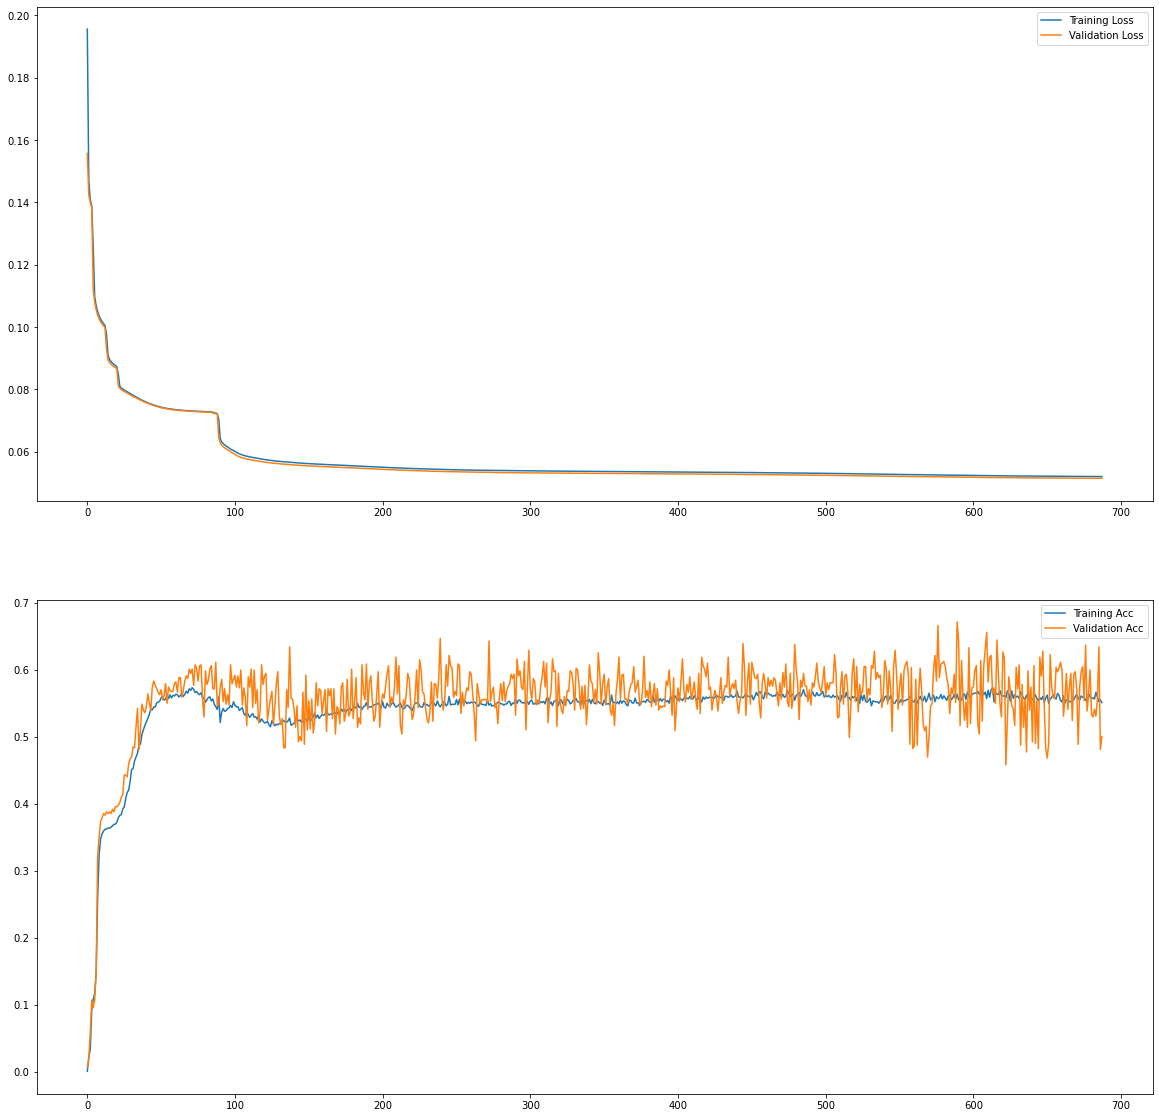

In [23]:
# 데이터 별 훈련결과 시각화
training_visualize(history)

In [24]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 3*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)
    
    # colunm별 절대 오차
    colunm_error = np.abs(pred_def - test_data)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect, colunm_error

In [25]:
# 확인
print(f"테스트 데이터 개수: {len(test_df_Y)}")
test_Y_defect, Y_CE = defective_decision(DAE, train_df, test_df_Y)

테스트 데이터 개수: 980
불량 개수:  9


In [26]:
# 확인
print(f"테스트 데이터 개수: {len(labeled_df_N_test)}")
test_N_defect, N_CE = defective_decision(DAE, train_df, labeled_df_N_test)

테스트 데이터 개수: 28
불량 개수:  16


In [27]:
true_val = np.concatenate([np.zeros(len(test_Y_defect)), np.ones(len(test_N_defect))])
predict_val = np.concatenate([test_Y_defect, test_N_defect])

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
confusion_matrix(true_val, predict_val)

array([[971,   9],
       [ 12,  16]], dtype=int64)

In [29]:
print("정확도: ", accuracy_score(true_val, predict_val))
print("정밀도: ", precision_score(true_val, predict_val))
print("재현율: ", recall_score(true_val, predict_val))
print("F1: ", f1_score(true_val, predict_val))

정확도:  0.9791666666666666
정밀도:  0.64
재현율:  0.5714285714285714
F1:  0.6037735849056605


In [31]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
#(latent_vector 시각화)

encoder = Model(inputs = input_img, outputs=encoder2)

latent_vector = encoder.predict(x_test)

rcParams['figure.figsize'] = 10, 8
fig = plt.figure(1)
ax = Axes3D(fig)

xs = latent_vector[:, 0]
ys = latent_vector[:, 1]
zs = latent_vector[:, 2]

color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']

for x, y, z, label in zip(xs, ys, zs, y_test):
  c=color[int(label)]
  ax.text(x,y,z,label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()

NameError: name 'input_img' is not defined

In [32]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter]
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
# CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

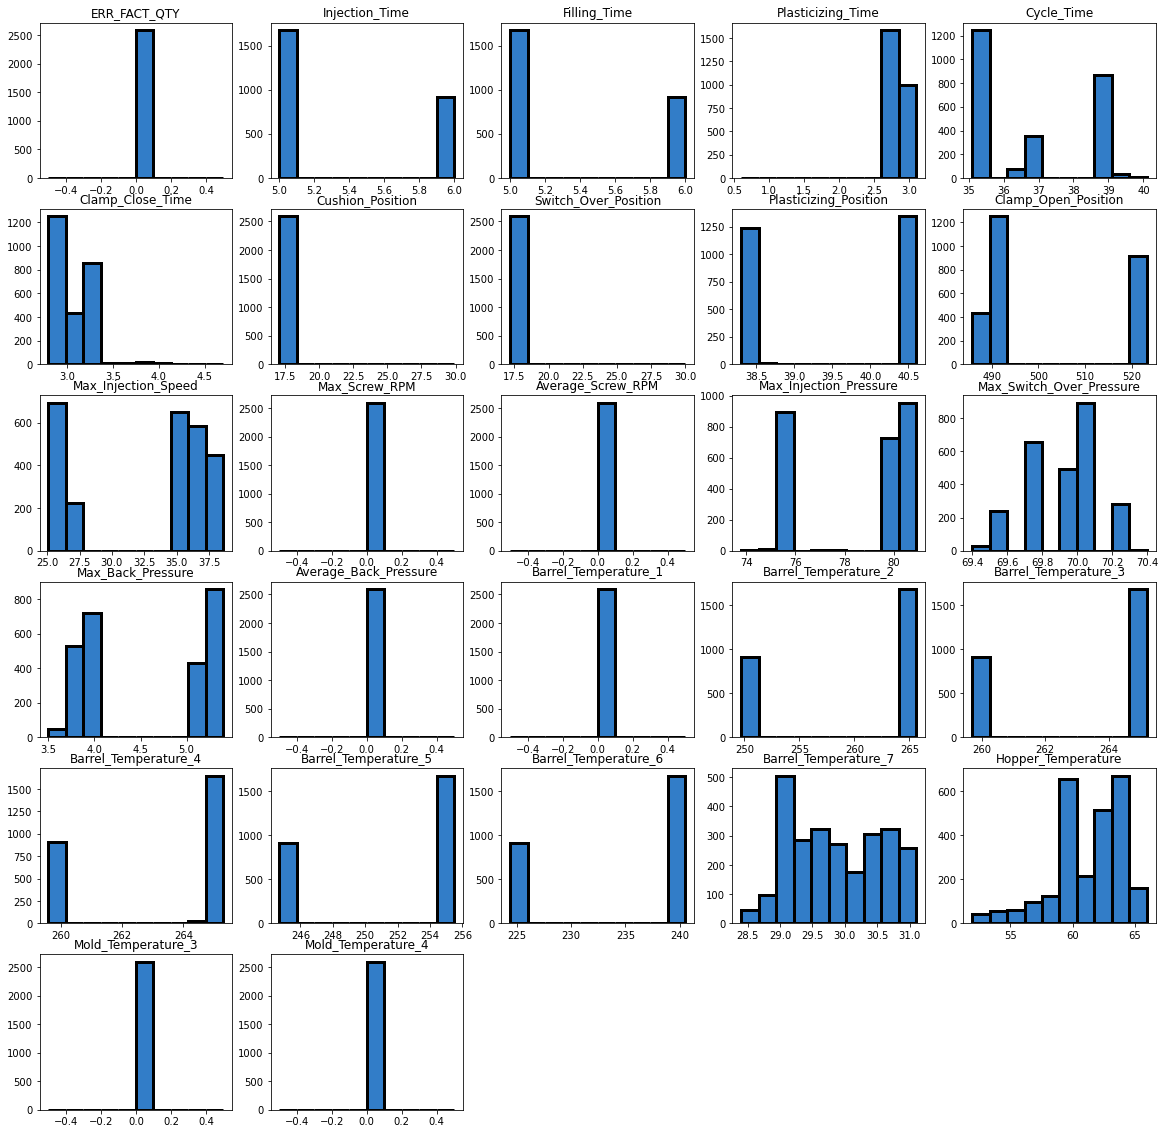

In [33]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] != 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

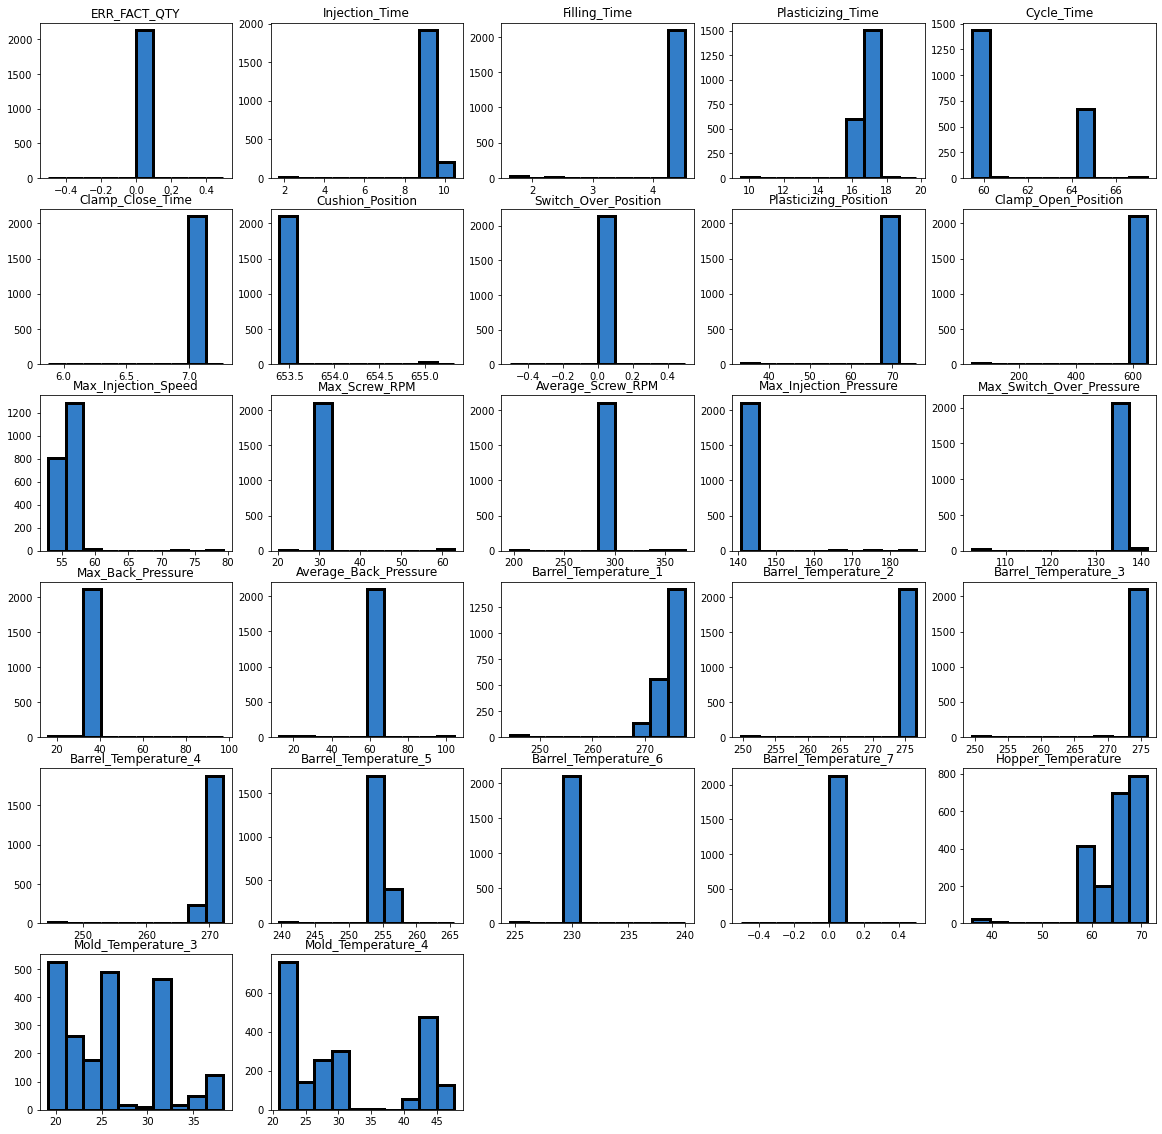

In [34]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [35]:
# 히스토그램 시각화
# test_df - 나누기 전

data = test_df[test_df["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

NameError: name 'test_df' is not defined

In [40]:
# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 히스토그램 시각화
visual_CN7_650T_1st_refine = CN7_650T_1st_refine.drop("TimeStamp", axis=1)
for index, value in enumerate(visual_CN7_650T_1st_refine):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(visual_CN7_650T_1st_refine[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

KeyError: 'PART_TYPE'

<Figure size 2160x2160 with 0 Axes>

In [41]:
# 비선형 regression

In [42]:
Filling_Time_list=[]
Plasticizing_Time_list=[]
Cushion_Position_list=[]
Plasticizing_Position_list=[]
Max_Injection_Speed_list=[]
Max_Screw_RPM_list=[]
Average_Screw_RPM_list=[]
Max_Injection_Pressure_list=[]
Max_Switch_Over_Pressure_list=[]
Average_Back_Pressure_list=[]
Barrel_Temperature_2_list=[]
Packing_Time_list=[]
Avg_Mold_Temperature_list=[]

for i in unsc_test_df:
    Filling_Time_list.append(i[0])
    Plasticizing_Time_list=[i[1]]
    Cushion_Position_list=[i[2]]
    Plasticizing_Position_list=[i[3]]
    Max_Injection_Speed_list=[i[4]]
    Max_Screw_RPM_list=[i[5]]
    Average_Screw_RPM_list=[i[6]]
    Max_Injection_Pressure_list=[i[7]]
    Max_Switch_Over_Pressure_list=[i[8]]
    Average_Back_Pressure_list=[i[9]]
    Barrel_Temperature_2_list=[i[10]]
    Packing_Time_list=[i[11]]
    Avg_Mold_Temperature_list=[i[12]]

In [43]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [52]:
for y in Y_CE:
    
    col1.append(y[0])
    col2.append(y[1])
    col3.append(y[2])
    col4.append(y[3])
    col5.append(y[4])
    col6.append(y[5])
    col7.append(y[6])
    col8.append(y[7])
    col9.append(y[8])
    col10.append(y[9])
    col11.append(y[10])
    col12.append(y[11])
    col13.append(y[12])

In [53]:
x=Filling_Time_list
y=col1

In [54]:
x=np.array(x).reshape(-1,1)
y=np.array(y).reshape(-1,1)

In [55]:
y.shape

(980, 1)

In [56]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False) # 기본 다항식형태를 만들고
x_poly = poly_features.fit_transform(x)

In [61]:
#회귀함수의 기울기가 0일 때 값 즉, optimazing value
x[0], x_poly[0]

(array([4.42]), array([ 4.42  , 19.5364]))

In [58]:
from sklearn.linear_model import LinearRegression
# model.coef_, model.intercept_
model = LinearRegression()
model.fit(x_poly, y) # 다항회귀 모델에 그렇게 변형한 데이터와 기존 y값을 넣고 학습시킨다.

LinearRegression()

In [59]:
# 데이터 변환 과정과 머신러닝을 연결해주는 파이프라인
from sklearn.pipeline import make_pipeline   

model_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                         LinearRegression())
model_lr.fit(x, y)
print(model_lr.steps[1][1].coef_)

[[25.92173091 -2.92516775]]


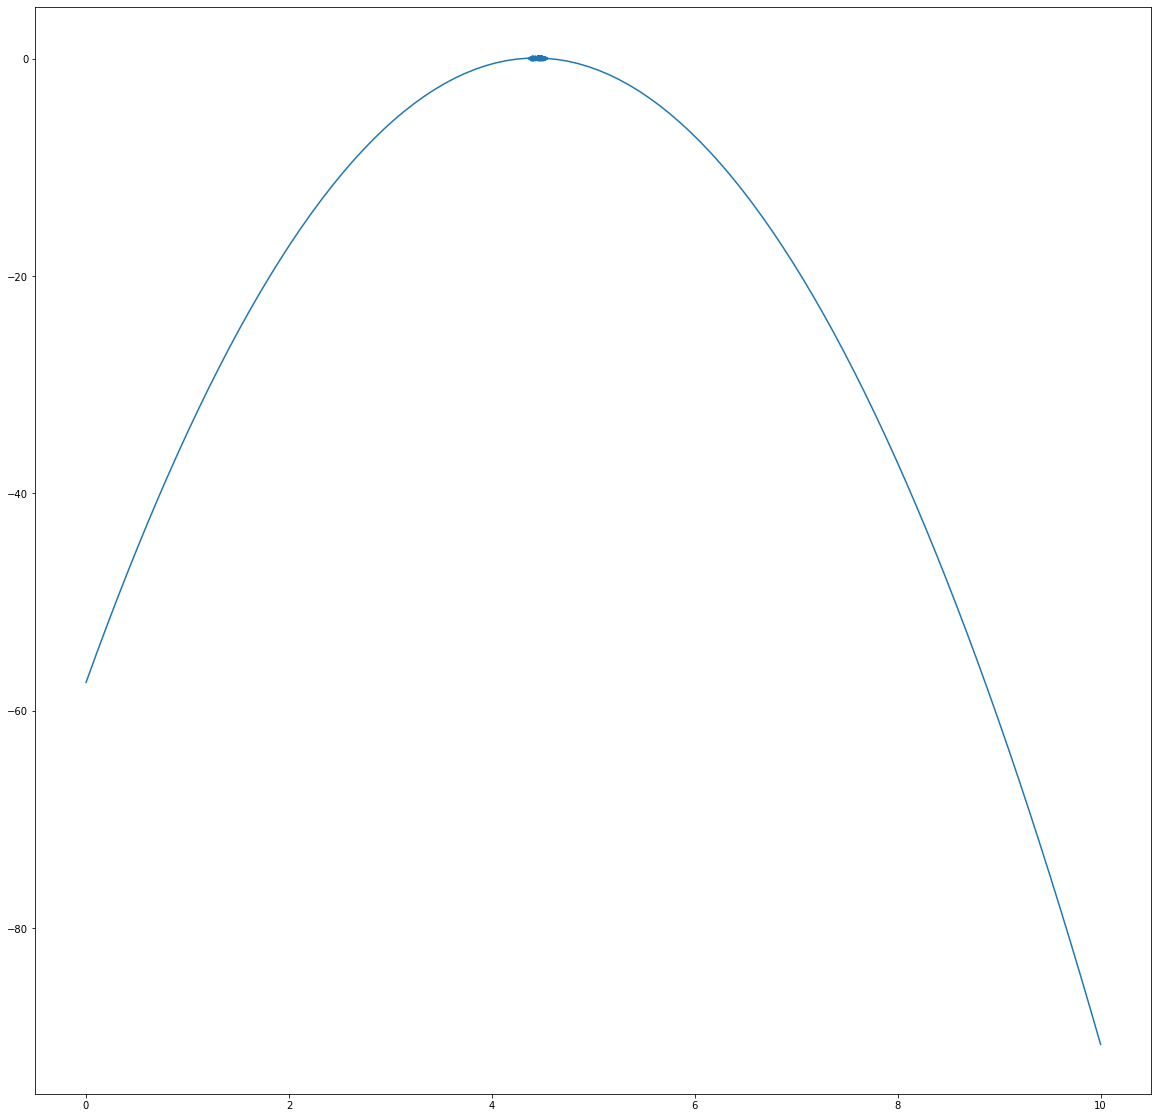

In [60]:
# 다항회귀 그래프
xx = np.linspace(0, 10, 100)
y_pred = model_lr.predict(xx[:, np.newaxis])
plt.plot(xx, y_pred)
plt.scatter(x, y, s=5)